In [ ]:
!pip install git+https://github.com/huggingface/transformers.git@main

  Cloning https://github.com/huggingface/transformers.git (to revision main) to /tmp/pip-req-build-es_p42t4
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-es_p42t4
  Resolved https://github.com/huggingface/transformers.git to commit 2c658b5a4282f2e824b4e23dc3bcda7ef27d5827
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q datasets

In [ ]:
from datasets import load_dataset

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Based on the following sources:

https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing  (Fine-tune GIT on an image captioning)

https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/image_captioning_blip.ipynb#scrollTo=4KNaYcxCqn8t&uniqifier=1

(image_captioning_blip)

In [ ]:
import time
epoch_not = 91
start_time = time.time()


dataset = load_dataset("imagefolder", data_dir="/content/drive/MyDrive/CSC490/CSC490 Project/ex_training")
dataset = dataset["train"].train_test_split(test_size=0.2)
print(dataset)

Resolving data files:   0%|          | 0/1383 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'pdf_hash', 'fig_uri', 'text'],
        num_rows: 1105
    })
    test: Dataset({
        features: ['image', 'pdf_hash', 'fig_uri', 'text'],
        num_rows: 277
    })
})


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
# partial credit:
# https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
      self.dataset = dataset
      self.processor = processor

    def __len__(self):
      return len(self.dataset)

    def __getitem__(self, idx):
      item = self.dataset[idx]
      encoding = self.processor(images=item["image"], text=item["text"],
                                padding="max_length", return_tensors="pt")
      # remove batch dimension
      encoding["input_ids"] = encoding["input_ids"][:, :512]  # Truncate if longer
      encoding["attention_mask"] = encoding["attention_mask"][:, :512]
      encoding = {k:v.squeeze() for k,v in encoding.items()}

      return encoding

In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
load_path = "/content/drive/MyDrive/CSC490/CSC490 Project/Models/fine_tuned_model_graphed3.pth"
model.load_state_dict(torch.load(load_path))

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

def my_collate_fn(data):
    # TODO: Implement your function
    # But I guess in your case it should be:
    print(data)
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    print("important!")
    print(data)
    print(target)
    print("end important!")
    data = processor(data, text=target, padding="max_length", return_tensors="pt")

    return data, target

def collate_fn(batch):
  try:
    keys = batch[0].keys()
    collated_batch = {}

    for key in keys:
      if isinstance(batch[0][key], torch.Tensor):
        if batch[0][key].ndim > 1:
          collated_batch[key] = pad_sequence([item[key] for item in batch], batch_first=True)
        else:
          collated_batch[key] = torch.stack([item[key] for item in batch])
      else:
        collated_batch[key] = [item[key] for item in batch]

    return collated_batch
  except RuntimeError as e:
    print(f"Error encountered with key: {key}")
    print("Sizes of items causing the error:")
    for item in batch:
        print(item[key].size())
    raise e

train_dataset = ImageCaptioningDataset(dataset["train"], processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=6, drop_last=True)

val_dataset = ImageCaptioningDataset(dataset["test"], processor)
validation_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=6, drop_last=True)
for obj in train_dataloader:
  if (str(obj['pixel_values'].shape) != "torch.Size([6, 1, 3, 384, 384])" or str(obj['input_ids'].shape) != "torch.Size([6, 1, 512])" or str(obj['attention_mask'].shape) != "torch.Size([6, 1, 512])"):
    print("ERROR!")
  print(obj['pixel_values'].shape)
  print(obj['input_ids'].shape)
  print(obj['attention_mask'].shape)

print(train_dataloader)
print(validation_dataloader)

In [ ]:
# Put model on the GPU for faster computation
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def generate_caption(image_index):
  example = dataset[image_index]
  image = example["image"]
  width, height = image.size
  display(image.resize((int(0.3*width), int(0.3*height))))

  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  print(generated_caption)
  print(dataset[image_index]["text"])

generate_caption(0)
generate_caption(1)
generate_caption(2)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


20 Train Loss: 1.6325457096099854
Validation Loss at iteration 20: 1.715464693048726
40 Train Loss: 2.473240375518799
Validation Loss at iteration 40: 1.713041214839272
60 Train Loss: 1.483553171157837
Validation Loss at iteration 60: 1.7060527568278105
80 Train Loss: 1.9323276281356812
Validation Loss at iteration 80: 1.7028108731560085
100 Train Loss: 1.9370473623275757
Validation Loss at iteration 100: 1.7031698278758838
120 Train Loss: 1.6900655031204224
Validation Loss at iteration 120: 1.7014806011448735
140 Train Loss: 1.541877269744873
Validation Loss at iteration 140: 1.7144132308338
160 Train Loss: 1.719942569732666
Validation Loss at iteration 160: 1.697796370672143
180 Train Loss: 2.1867501735687256
Validation Loss at iteration 180: 1.6942904772965803
Epoch 1 completed in 717.11 seconds
Epoch: 1
200 Train Loss: 1.4649542570114136
Validation Loss at iteration 200: 1.6970190846401711
220 Train Loss: 1.6189888715744019
Validation Loss at iteration 220: 1.6929861255314038
240 T

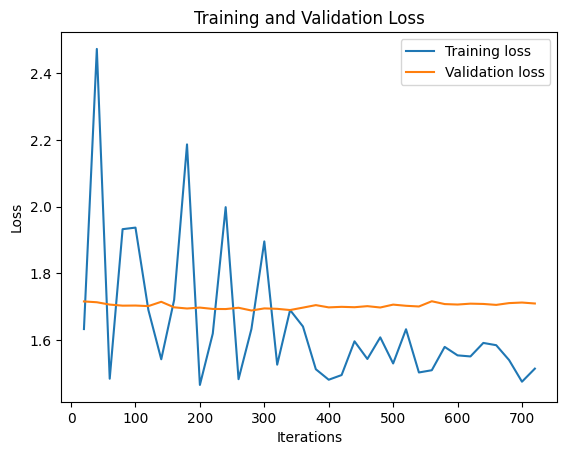

In [ ]:
# train and validation
import torch
import time
import matplotlib.pyplot as plt

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
iters, train_loss, val_loss = [], [], []
iter_count = 0
gradient_accumulation_steps = 4
patience = 3  # Patience for early stopping
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(100):
    start_time = time.time()
    print("Epoch:", epoch)

    model.train()
    running_loss = 0.0
    for step, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)
        loss = outputs.loss # loss is set to contrastive loss for image captioning

        loss = loss / gradient_accumulation_steps  # Normalize loss
        loss.backward()
        running_loss += loss.item()

        if (step + 1) % gradient_accumulation_steps == 0 or (step + 1) == len(train_dataloader): # implementing gradient accumulation
            optimizer.step()
            optimizer.zero_grad()

        if step % 20 == 0:
            print(step, "Train Loss:", running_loss / 20)
            running_loss = 0.0

    # Validation loop
    model.eval()
    val_losses = []
    with torch.no_grad():
        for val_batch in validation_dataloader:
            val_input_ids = val_batch.pop("input_ids").to(device)
            val_pixel_values = val_batch.pop("pixel_values").to(device)

            val_outputs = model(input_ids=val_input_ids, pixel_values=val_pixel_values, labels=val_input_ids)
            val_losses.append(val_outputs.loss.item())

    mean_val_loss = sum(val_losses) / len(val_losses)
    print(f'Validation Loss after epoch {epoch}: {mean_val_loss}')

    # Check for early stopping
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

    save_path = f"/content/drive/MyDrive/CSC490/CSC490 Project/fine_tuned_model_ex{epoch}.pth"
    torch.save(model.state_dict(), save_path)

plt.figure()
plt.plot(iters[:len(train_loss)], train_loss, label='Training loss')
plt.plot(iters[:len(val_loss)], val_loss, label='Validation loss')
plt.title("Training and Validation Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
import pickle
file_path = '/content/drive/My Drive/CSC490/CSC490 Project/results/graphed_loss_ex.pkl'
loss = []
loss.append(train_loss)
loss.append(val_loss)

with open(file_path, 'wb') as file:
    pickle.dump(loss, file)

Epoch: 0
20 Loss: 1.550730586051941
40 Loss: 1.5402121543884277
Epoch 1 completed in 94.79 seconds
Epoch: 1
60 Loss: 1.4769858121871948
80 Loss: 1.5552603006362915
100 Loss: 1.602652668952942
Epoch 2 completed in 95.08 seconds
Epoch: 2
120 Loss: 1.4668395519256592
140 Loss: 1.4681917428970337
Epoch 3 completed in 93.76 seconds
Epoch: 3
160 Loss: 1.3955501317977905
180 Loss: 1.4458194971084595
200 Loss: 1.3981016874313354
Epoch 4 completed in 94.61 seconds


Text(0, 0.5, 'Loss')

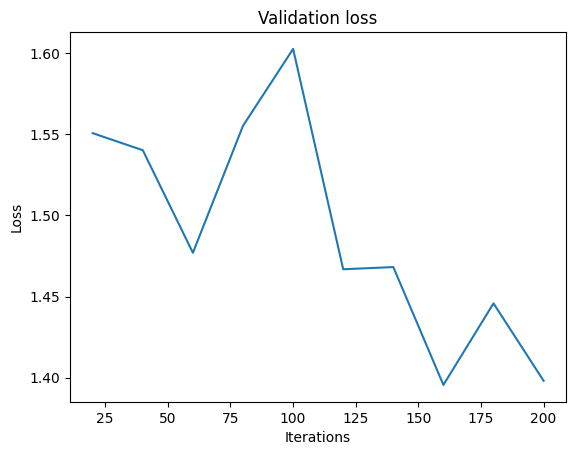

In [ ]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
iters, train_loss = [], []
iter_count = 0 # count the number of iterations that has passed

for epoch in range(4):
  start_time = time.time()  # Capture start time
  print("Epoch:", epoch)
  # partial credit: https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    iter_count += 1
    if iter_count % 20 == 0:
      iters.append(iter_count)
      train_loss.append(float(loss))
      print(iter_count, "Loss:", float(loss))

  end_time = time.time()
  epoch_duration = end_time - start_time
  print(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")


  # save_path = "/content/drive/MyDrive/CSC490_MONDAY_PREP/fine_tuned_model_graphed" + str(epoch) + ".pth"
  # torch.save(model.state_dict(), save_path)

plt.figure()
plt.plot(iters[:len(train_loss)], train_loss)
plt.title("Validation loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")

In [ ]:
generate_caption(0)
generate_caption(1)
generate_caption(2)